In [2]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import re
!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score,ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score
from sklearn import metrics

  Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
  Using cached regex-2024.11.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (781 kB)


In [3]:
!pip install chardet
import chardet

with open("spam.csv", "rb") as f:
    result = chardet.detect(f.read(10000))  
    print(result)


  Using cached chardet-5.2.0-py3-none-any.whl (199 kB)
{'encoding': 'Windows-1252', 'confidence': 0.7261670208776098, 'language': ''}


In [4]:
data = pd.read_csv("spam.csv", encoding="Windows-1252")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
to_drop = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"]
data = data.drop(columns=to_drop)  # Dropping unnecessary columns

# Renaming the columns for better readability
data.rename(columns={"v1": "Target", "v2": "Text"}, inplace=True)

data.head()


,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Data Exploration

In [6]:
print(data.isnull().sum())  # Count missing values per column
print(data["Target"].value_counts())  # Check spam vs. ham distribution


Target    0
Text      0
dtype: int64
Target
ham     4825
spam     747
Name: count, dtype: int64


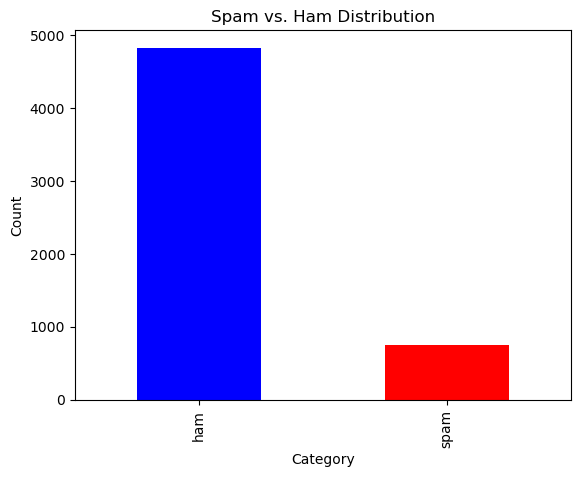

In [7]:
#visualisation
data["Target"].value_counts().plot(kind="bar", color=["blue", "red"])
plt.title("Spam vs. Ham Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


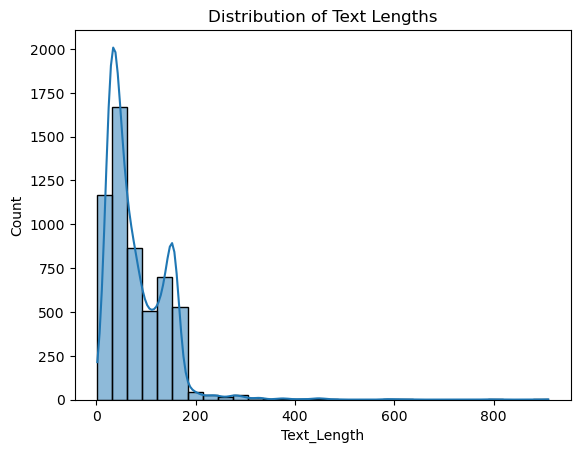

In [8]:
#Check message length distribution
data["Text_Length"] = data["Text"].apply(len)  # Create a new column for text length

import seaborn as sns
sns.histplot(data["Text_Length"], bins=30, kde=True)
plt.title("Distribution of Text Lengths")
plt.show()


  Using cached wordcloud-1.9.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511 kB)


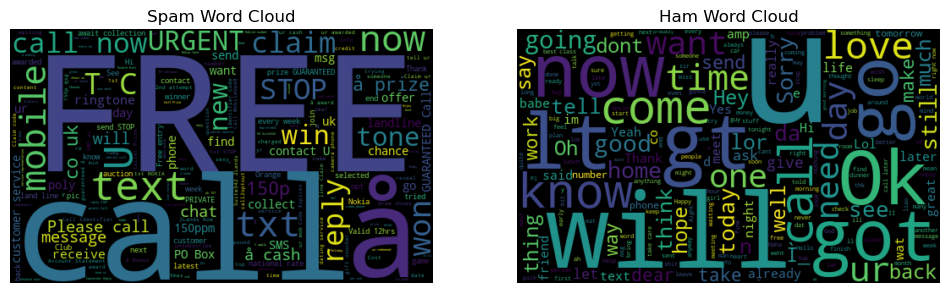

In [9]:
#most frequent words
!pip install wordcloud
from wordcloud import WordCloud

spam_words = " ".join(data[data["Target"] == "spam"]["Text"])
ham_words = " ".join(data[data["Target"] == "ham"]["Text"])

spam_wc = WordCloud(width=500, height=300, background_color="black").generate(spam_words)
ham_wc = WordCloud(width=500, height=300, background_color="black").generate(ham_words)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(spam_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Spam Word Cloud")

plt.subplot(1, 2, 2)
plt.imshow(ham_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Ham Word Cloud")

plt.show()


In [10]:
#word count per message
data["Word_Count"] = data["Text"].apply(lambda x: len(x.split()))
print(data[["Target", "Word_Count"]].groupby("Target").mean())  # Avg words in spam vs ham


        Word_Count
Target            
ham      14.200622
spam     23.851406


In [11]:
#character count per message 
data["Char_Count"] = data["Text"].apply(len)
print(data[["Target", "Char_Count"]].groupby("Target").mean())  # Avg characters in spam vs ham


        Char_Count
Target            
ham      71.023627
spam    138.866131


### Tokenisation

In [12]:
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [13]:

# Adding a column for the number of characters
data["No_of_Characters"] = data["Text"].apply(len)

# Adding a column for the number of words
data["No_of_Words"] = data["Text"].apply(lambda x: len(nltk.word_tokenize(x)))

# Adding a column for the number of sentences
data["No_of_Sentences"] = data["Text"].apply(lambda x: len(nltk.sent_tokenize(x)))

# Displaying summary statistics
data.describe().T


,count,mean,std,min,25%,50%,75%,max
Text_Length,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
Word_Count,5572.0,15.494436,11.329427,1.0,7.0,12.0,23.0,171.0
Char_Count,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_Words,5572.0,18.699390,13.741932,1.0,9.0,15.0,27.0,220.0
No_of_Sentences,5572.0,1.996411,1.520159,1.0,1.0,1.5,2.0,38.0


In [14]:
# Dropping rows where the number of characters is greater than 350
data = data[(data["No_of_Characters"] < 350)]

# Checking the new shape of the dataset after outlier removal
data.shape


(5548, 8)

### Preprocessing

In [15]:
#Lowercasing
data.loc[:, "Text"] = data["Text"].apply(lambda x: x.lower())

In [16]:
#Removing punctuation
import string

data.loc[:,"Text"] = data["Text"].apply(lambda x: x.translate(str.maketrans("", "", string.punctuation)))


In [17]:
#Tokenisation
data.loc[:, "Tokens"] = data["Text"].apply(nltk.word_tokenize)


In [18]:
#remove stopwords
from nltk.corpus import stopwords

# Download stopwords if not done already
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

data.loc[:,"Tokens"] = data["Tokens"].apply(lambda x: [word for word in x if word not in stop_words])


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
#Lemmatization
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

data["Lemmatize"] = data["Tokens"].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])


[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
# Step 1: Lowercasing
data["Text"] = data["Text"].apply(lambda x: x.lower())
print("After Lowercasing:")
print(data["Text"].head(), "\n")

# Step 2: Removing Punctuation
data["Text"] = data["Text"].apply(lambda x: x.translate(str.maketrans("", "", string.punctuation)))
print("After Removing Punctuation:")
print(data["Text"].head(), "\n")

# Step 3: Tokenization
data["Tokens"] = data["Text"].apply(nltk.word_tokenize)
print("After Tokenization:")
print(data["Tokens"].head(), "\n")

# Step 4: Removing Stop Words
stop_words = set(stopwords.words('english'))
data["Tokens"] = data["Tokens"].apply(lambda x: [word for word in x if word not in stop_words])
print("After Removing Stop Words:")
print(data["Tokens"].head(), "\n")

# Step 5: Lemmatization
lemmatizer = WordNetLemmatizer()
data["Lemmatize"] = data["Tokens"].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
print("After Lemmatization:")
print(data["Tokens"].head(), "\n")

# Step 6: Rejoining Tokens into Text
data["Processed_Text"] = data["Tokens"].apply(lambda x: " ".join(x))
print("After Rejoining Tokens into Text:")
print(data["Processed_Text"].head(), "\n")

After Lowercasing:
0    go until jurong point crazy available only in ...
1                              ok lar joking wif u oni
2    free entry in 2 a wkly comp to win fa cup fina...
3          u dun say so early hor u c already then say
4    nah i dont think he goes to usf he lives aroun...
Name: Text, dtype: object 

After Removing Punctuation:
0    go until jurong point crazy available only in ...
1                              ok lar joking wif u oni
2    free entry in 2 a wkly comp to win fa cup fina...
3          u dun say so early hor u c already then say
4    nah i dont think he goes to usf he lives aroun...
Name: Text, dtype: object 

After Tokenization:
0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, dont, think, he, goes, to, usf, he, l...
Name: Tokens, dtype: object 

After Removing Stop Wo

### Vectorization

In [21]:
data.loc[:,"Processed_Text"] = data["Tokens"].apply(lambda x: " ".join(x))


In [22]:
corpus= []
for i in data["Lemmatize"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
    
corpus[:5]
print("\033[1m\u001b[45;1m The First 5 lines in corpus :\033[0m",*corpus[:5], sep = "\n")

 The First 5 lines in corpus :
go jurong point crazy available bugis n great world la e buffet cine got amore wat
ok lar joking wif u oni
free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questionstd txt ratetcs apply 08452810075over18s
u dun say early hor u c already say
nah dont think go usf life around though


In [23]:

# Vectorize the cleaned corpus
tfidf = TfidfVectorizer(min_df=1)
X = tfidf.fit_transform(corpus).toarray()

print("Feature matrix shape:", X.shape)
print("Data type of the feature matrix:", X.dtype)


Feature matrix shape: (5548, 8718)
Data type of the feature matrix: float64


### Model building

In [44]:
# Features (X) and Target (y)
X = data["Processed_Text"]  # The processed text is used as the features
y = data["Target"]  # The target variable (spam or not spam)


In [45]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [46]:
print(X_train.shape)  # Should print (num_samples, num_features)
print(type(X_train))  # Should print <class 'numpy.ndarray'>
print(X_train[:5])  # Should show numerical values


(4438,)
<class 'pandas.core.series.Series'>
2455    abeg make profit start using get sponsors next...
3103               thats said bad dat e gals know u wat u
3887                                      oktake careumma
1218                   kkim also finewhen complete course
832     dear voucher holder claim weeks offer pc pleas...
Name: Processed_Text, dtype: object


In [47]:
# Create pipelines for each model
models = {
    "Naive Bayes": Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("nb", MultinomialNB())
    ]),
    "Random Forest": Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("rf", RandomForestClassifier(random_state=42))
    ]),
    "K-Neighbors": Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("knn", KNeighborsClassifier())
    ]),
    "Support Vector Machine": Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("svm", SVC(random_state=42))
    ])
}


In [48]:
# Fit all models on the training data
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    print(f"{model_name} trained successfully!\n")


Training Naive Bayes...
Naive Bayes trained successfully!

Training Random Forest...
Random Forest trained successfully!

Training K-Neighbors...
K-Neighbors trained successfully!

Training Support Vector Machine...
Support Vector Machine trained successfully!



In [49]:
import numpy as np
from sklearn.model_selection import cross_val_score

# Perform cross-validation for each model
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")  # 5-fold cross-validation
    print(f"{model_name} cross-validation accuracy: {np.mean(cv_scores):.4f}")


Naive Bayes cross-validation accuracy: 0.9574
Random Forest cross-validation accuracy: 0.9716
K-Neighbors cross-validation accuracy: 0.9060
Support Vector Machine cross-validation accuracy: 0.9739


### Model Evaluation: Accuracy & Confusion Matrix


In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

for model_name, model in models.items():
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"🔹 {model_name} Accuracy: {accuracy:.4f}")

    # Display confusion matrix
    print(f"🔹 {model_name} Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")

    # Detailed classification report
    print(f"🔹 {model_name} Classification Report:\n{classification_report(y_test, y_pred)}\n")


🔹 Naive Bayes Accuracy: 0.9649
🔹 Naive Bayes Confusion Matrix:
[[974   0]
 [ 39  97]]

🔹 Naive Bayes Classification Report:
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       974
        spam       1.00      0.71      0.83       136

    accuracy                           0.96      1110
   macro avg       0.98      0.86      0.91      1110
weighted avg       0.97      0.96      0.96      1110


🔹 Random Forest Accuracy: 0.9775
🔹 Random Forest Confusion Matrix:
[[974   0]
 [ 25 111]]

🔹 Random Forest Classification Report:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       974
        spam       1.00      0.82      0.90       136

    accuracy                           0.98      1110
   macro avg       0.99      0.91      0.94      1110
weighted avg       0.98      0.98      0.98      1110


🔹 K-Neighbors Accuracy: 0.9081
🔹 K-Neighbors Confusion Matrix:
[[974   0]
 [102  34]]

🔹 K

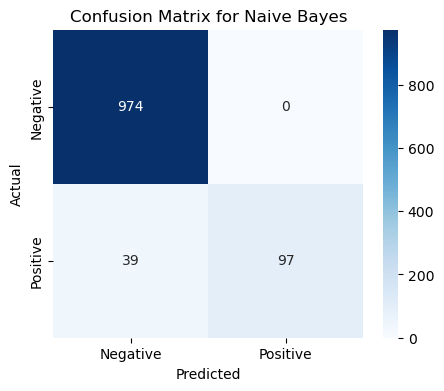

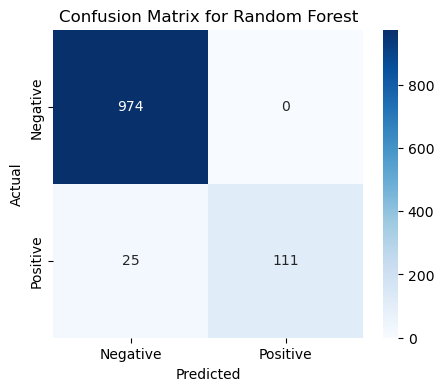

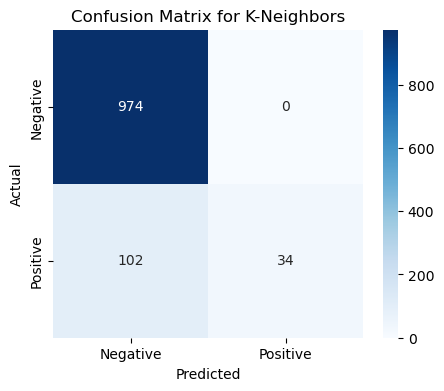

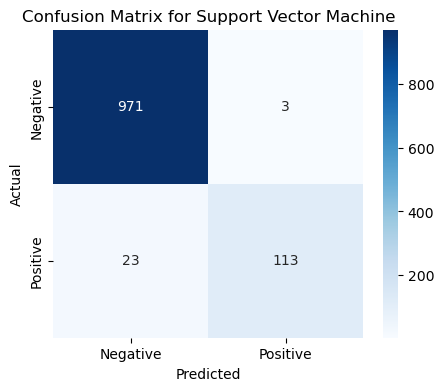

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, model_name)
